In [273]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np

#read the data
total_cases = pd.read_csv('https://covid.ourworldindata.org/data/total_cases.csv')
total_deaths = pd.read_csv('https://covid.ourworldindata.org/data/total_deaths.csv')
daily_cases = pd.read_csv('https://covid.ourworldindata.org/data/new_cases.csv')
daily_deaths = pd.read_csv('https://covid.ourworldindata.org/data/new_deaths.csv')
full_set = pd.read_csv('https://covid.ourworldindata.org/data/full_data.csv')
amount_of_tests = pd.read_csv('covid-19-tests-country.csv')
tests_per_million = pd.read_csv('covid19-tests-per-million-people.csv')

full_set = full_set.fillna(0)
full_set['date'] = pd.to_datetime(full_set['date'])

#make list of all locations in the data
all_locations = list(set(full_set['location']))
full_set.head()

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,0.0,0.0,1,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1,0.0
3,2020-02-28,Afghanistan,0.0,0.0,1,0.0
4,2020-02-29,Afghanistan,0.0,0.0,1,0.0


In [385]:
### Functions used

## Function to add the growth_rate for a given city
def growt_rate(dataframe, city):
    '''Function to build dataframe for a given city, adding growth rate'''
    # Add a growth rate for a country
    df_GR = dataframe.loc[dataframe['location']== city]
    df_GR = df_GR.loc[df_GR['total_cases'] >= 5]
    df_GR = df_GR.reset_index()

    # calculate GR
    SK_GR =[0.0] + [(df_GR['new_cases'][i+1] /df_GR['new_cases'][i]) for i in range(len(df_GR)-1)]
    df_GR['GR'] = SK_GR

    #replace inf and NaN with 0
    df_GR = df_GR.replace([np.inf, -np.inf], np.nan)
    df_GR = df_GR.replace(np.NaN,0)
    return df_GR

#test function
#df_growthrate = growt_rate(full_set, 'Netherlands' )
#df_growthrate.head()

## Function to plot total cases
def plot_total_cases(country_list, title):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(20,15))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date']
        y = full_set.loc[full_set['location']== item]['total_cases']
        plt.plot(x,y, label=item)

    plt.ylabel("Amount of infections")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()
    
#test_list = ['Netherlands', 'Italy']
#plot_total_cases(test_list, 'total cases for italy vs nl')

## Function to plot new cases
def plot_new_cases(country_list, title, start = 0, height=10, width=20):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(width,height))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date'][start:]
        y = full_set.loc[full_set['location']== item]['new_cases'][start:]
        plt.plot(x,y, label=item)

    plt.ylabel("Amount of new cases")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

#Function to plot deaths per country
def plot_death_cases(country_list, title, start = 0, height=10, width=20):
    """Function to plot the given countries total cases over time, takes an list of countries as input"""
    plt.figure(figsize=(width,height))
    for item in country_list:
        x = full_set.loc[full_set['location']== item]['date'][start:]
        y = full_set.loc[full_set['location']== item]['total_deaths'][start:]
        plt.plot(x,y, label=item)

    plt.ylabel("Amount of deaths")
    plt.xlabel('Date range')
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.legend()
    plt.show()

def death_rate(dataframe, city):
    '''Function to build dataframe for a given city, adding growth rate'''
    # Add a growth rate for a country
    df_dr = dataframe.loc[dataframe['location']== city]
    #df_dr = df_GR.loc[df_GR['total_cases'] >= 5]
    df_dr = df_dr.reset_index()

    # calculate DR
    deathrate = [(df_dr['total_deaths'][i] /df_dr['total_cases'][i]) for i in range(len(df_dr))]
    df_dr['DR'] = deathrate

    #replace inf and NaN with 0
    #df_GR = df_GR.replace([np.inf, -np.inf], np.nan)
    #df_GR = df_GR.replace(np.NaN,0)
    df_dr = df_dr.loc[df_dr['DR'] < 1]
    return df_dr

#test_list = ['Netherlands', 'Italy']
#plot_new_cases(test_list, 'new cases over time for NL and IT')
death_rate(full_set, 'Netherlands')

,index,date,location,new_cases,new_deaths,total_cases,total_deaths,DR
0,1418,2020-02-28,Netherlands,0.0,0.0,1,0.0,0.000000
1,1419,2020-02-29,Netherlands,1.0,0.0,2,0.0,0.000000
2,1420,2020-03-01,Netherlands,5.0,0.0,7,0.0,0.000000
3,1421,2020-03-02,Netherlands,6.0,0.0,13,0.0,0.000000
4,1422,2020-03-03,Netherlands,5.0,0.0,18,0.0,0.000000
5,1423,2020-03-04,Netherlands,10.0,0.0,28,0.0,0.000000
6,1424,2020-03-05,Netherlands,10.0,0.0,38,0.0,0.000000
7,1425,2020-03-06,Netherlands,44.0,0.0,82,0.0,0.000000
8,1426,2020-03-07,Netherlands,46.0,0.0,128,1.0,0.007812
9,1427,2020-03-08,Netherlands,60.0,0.0,188,1.0,0.005319


In [306]:
range(len(df_GR))

range(0, 46)

# Calculate Growth Rate
The growth rate for countries with more then 50 cases is calculated. We start looking from a moment when there are more then 5 cases know in a country.

In [275]:
# Make a list with cities with more total_cases then threshold
threshold = 50
more_then = full_set.loc[full_set['date']== '2020-03-13']
more_then = more_then.loc[full_set['total_cases'] >= threshold]
more_then_c_list = list(more_then['location'])
more_then_c_list.remove('International')
more_then_c_list.remove('World')

#Calculate the growth_rates, build a model
growth_rates = []
for country in more_then_c_list:
    # Add a growth rate for a country
    
    
    growth_rates.append([country, growt_rate(full_set, country)['GR'].mean()])
    
df = pd.DataFrame.from_records(growth_rates)
df = df.dropna()
df.to_csv('test.csv')   #write to csv for further processing of the visualization.
df = df.sort_values(1)

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

invalid value encountered in double_scalars



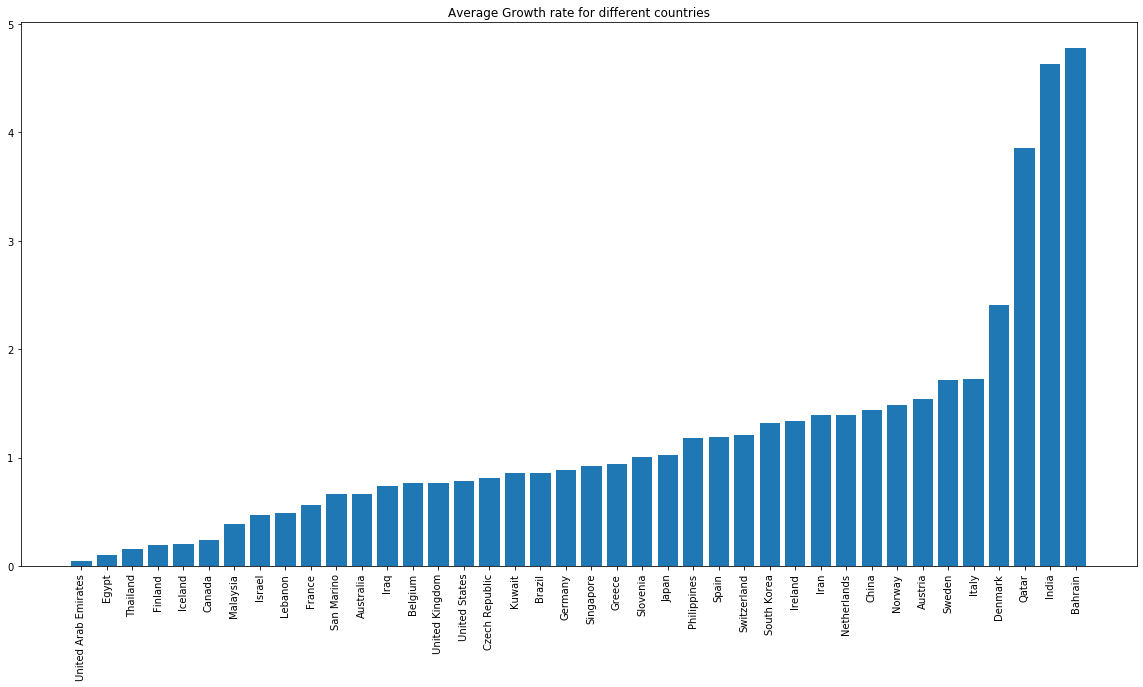

In [276]:
# Plot a bar-chart with growth-rate
plt.figure(figsize=(20,10))
plt.bar(df[0], df[1], width=0.8)

plt.title('Average Growth rate for different countries')
plt.xticks(rotation = 90)
plt.show()

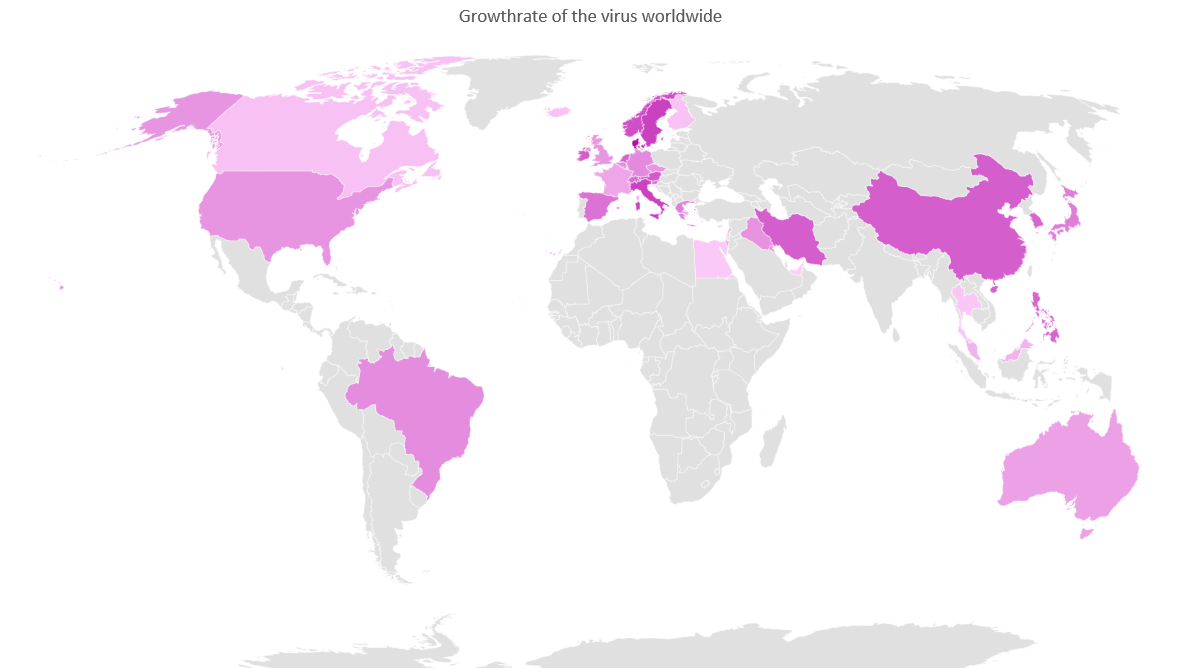

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars



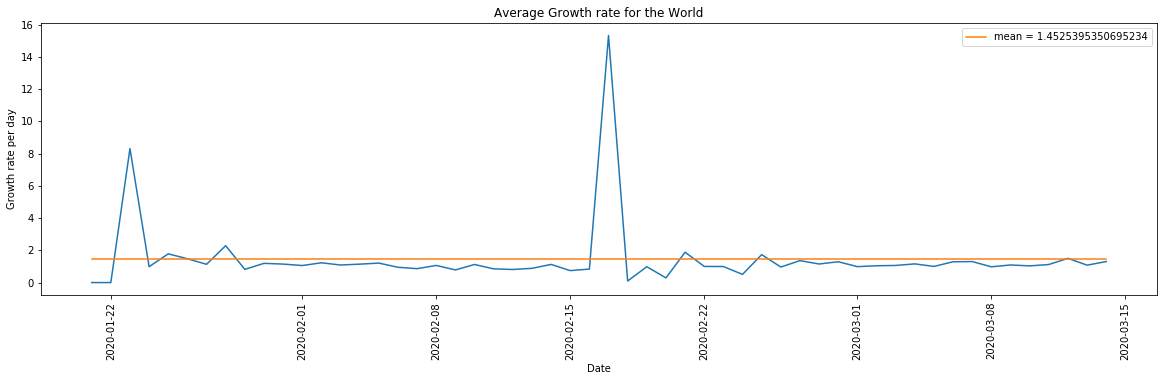

In [277]:
# plot the development of the growtrate for the world:

plt.figure(figsize=(20,5))
plt.plot(growt_rate(full_set, 'World')['date'], growt_rate(full_set, 'World')['GR'])
ymean = [growt_rate(full_set, 'World')['GR'].mean() for date in range(len(growt_rate(full_set, 'World')['date']))]
plt.plot(growt_rate(full_set, 'World')['date'], ymean, label='mean = {}'.format(ymean[0]))

plt.ylabel("Growth rate per day")
plt.xlabel('Date')
plt.title('Average Growth rate for the World')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

C:\Users\_Vinc\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning:

divide by zero encountered in double_scalars



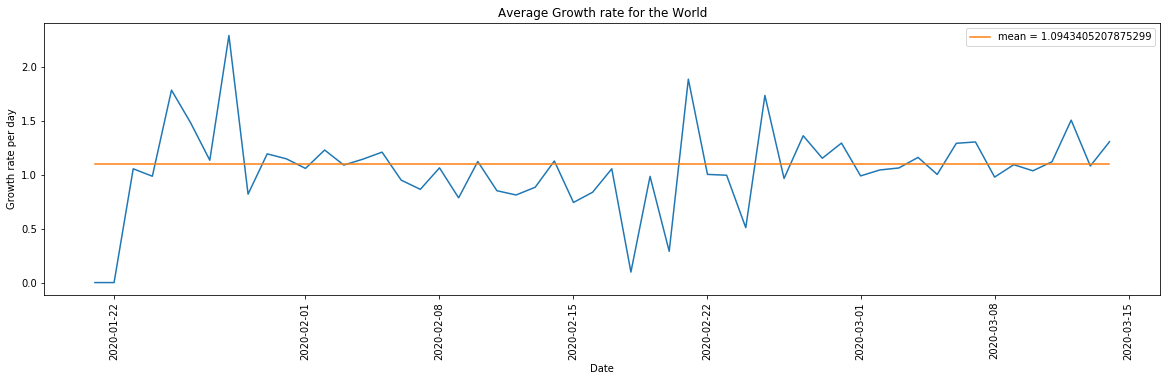

In [278]:
# Now without the exponential growth outliers (x8 in the beginning, x15 when spread to the rest of the world)
growt_rate(full_set, 'World')

plt.figure(figsize=(20,5))
ygr = [x if x < 4 else sts.mean([x for x in ygr if x <4]) for x in growt_rate(full_set, 'World')['GR']]
plt.plot(growt_rate(full_set, 'World')['date'], ygr)
ymean = [sts.mean(ygr[2:]) for date in range(len(growt_rate(full_set, 'World')['date']))]
plt.plot(growt_rate(full_set, 'World')['date'], ymean, label='mean = {}'.format(ymean[0]))

plt.ylabel("Growth rate per day")
plt.xlabel('Date')
plt.title('Average Growth rate for the World')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

# Plot the total cases in the world
We plot the cases that have more then 50 infections in total

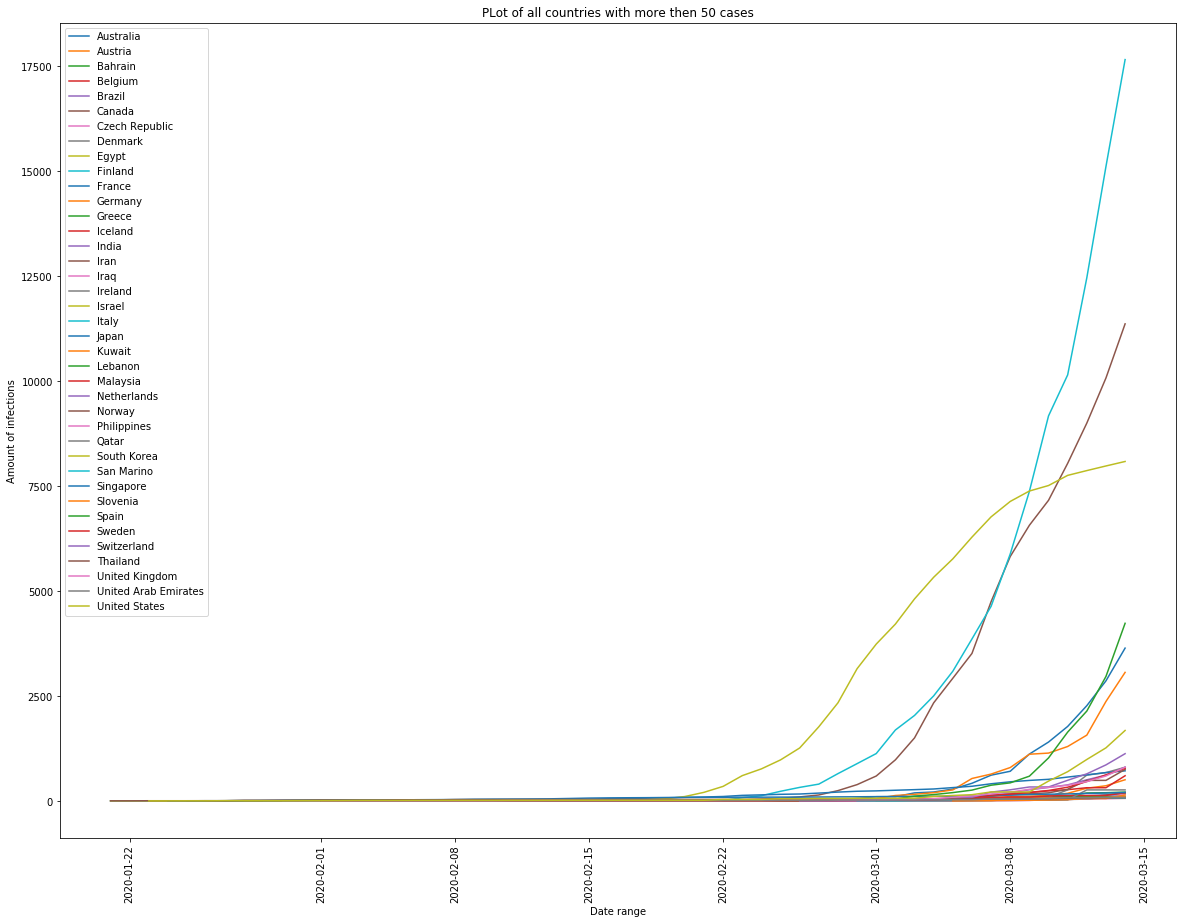

In [281]:
# plot dutch cases against Italian cases
more_then_c_list.remove('China')
plot_total_cases(more_then_c_list, 'PLot of all countries with more then 50 cases')

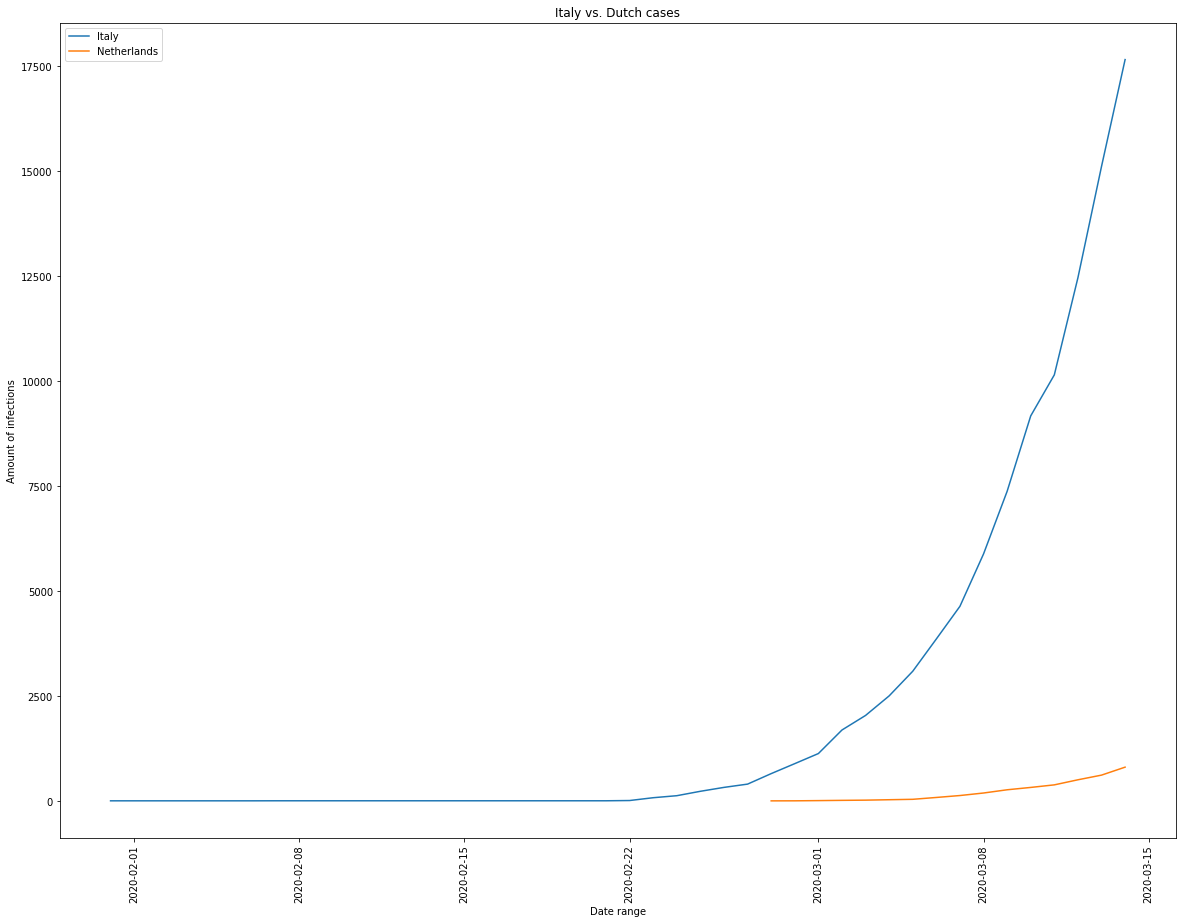

In [282]:
# plot dutch cases against Italian cases
country_list = ['Italy', 'Netherlands']
plot_total_cases(country_list, 'Italy vs. Dutch cases')

In [283]:
#lets make it more interactive with plotly
import plotly.graph_objects as go
traces_list = []
for item in more_then_c_list:
    x = full_set.loc[full_set['location'] == item]['date']

    trace = go.Scatter(x=x,
            y=full_set.loc[full_set['location'] == item]['total_cases'],
            name = item,
            )
    traces_list.append(trace)

Layout = go.Layout(xaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                   yaxis=dict(showgrid=True, zeroline=True, showticklabels=True),
                   xaxis_title="Days since outbreak",
                   yaxis_title="Amount of infected",
                    )

fig = go.Figure(data=traces_list, layout=Layout)
fig

# Lets look at new cases only
look at how the new cases are evolving over time, is there a logistic relation?

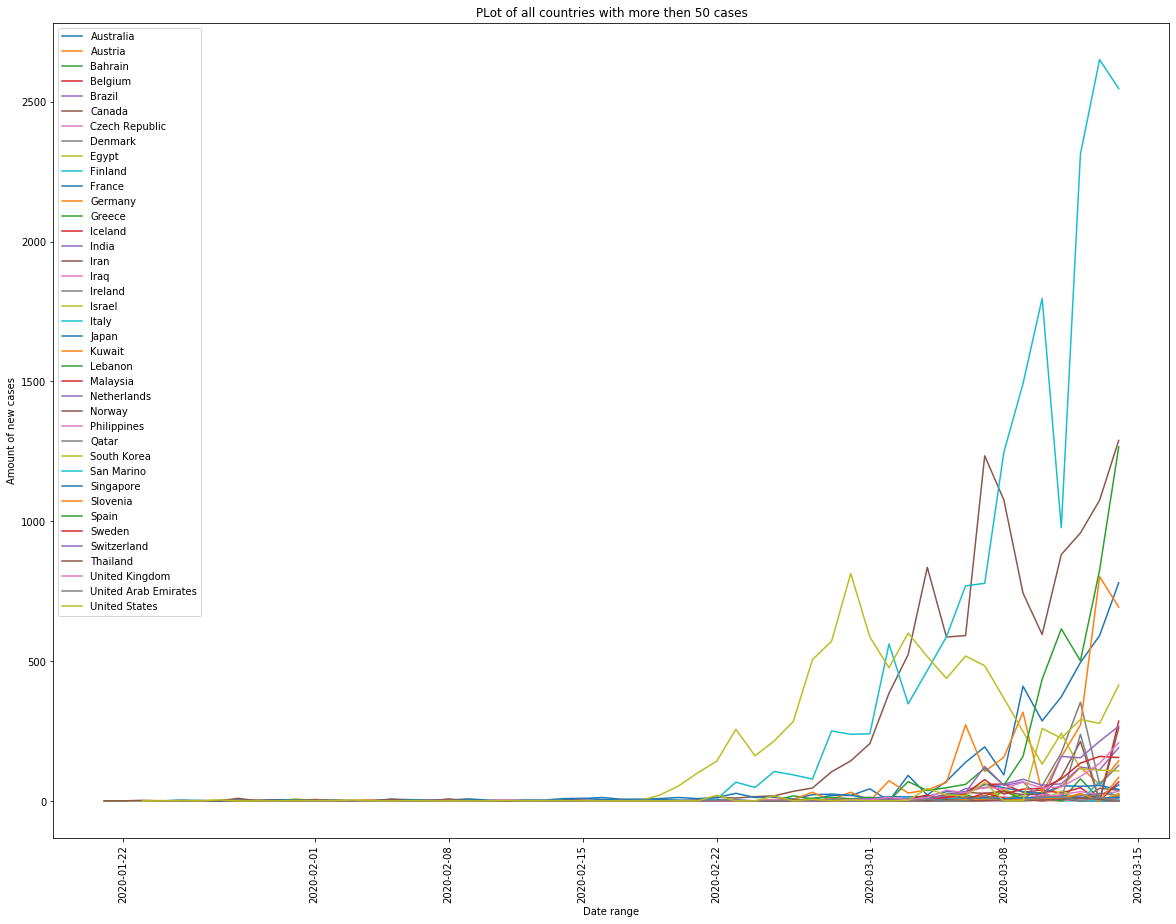

In [290]:
plot_new_cases(more_then_c_list, 'PLot of all countries with more then 50 cases')

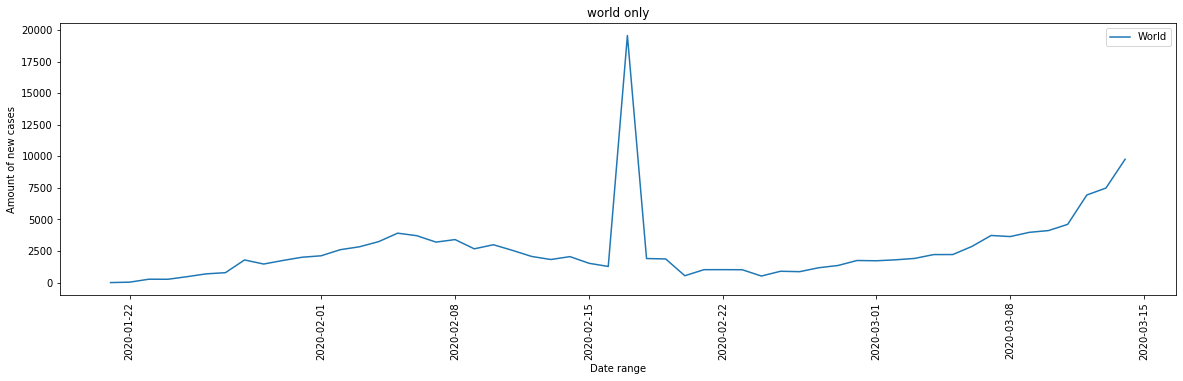

In [295]:
plot_new_cases(['World'], 'world only', height=5)

# look at Deaths per country
analysis on the amount of deaths per country

In [342]:
#First define a list with countries with reported deaths
c_with_deaths = list(set(full_set.loc[full_set['total_deaths'] > 1]['location']))
c_with_deaths.remove('International')
c_with_deaths.remove('World')
#c_with_deaths.remove('China')

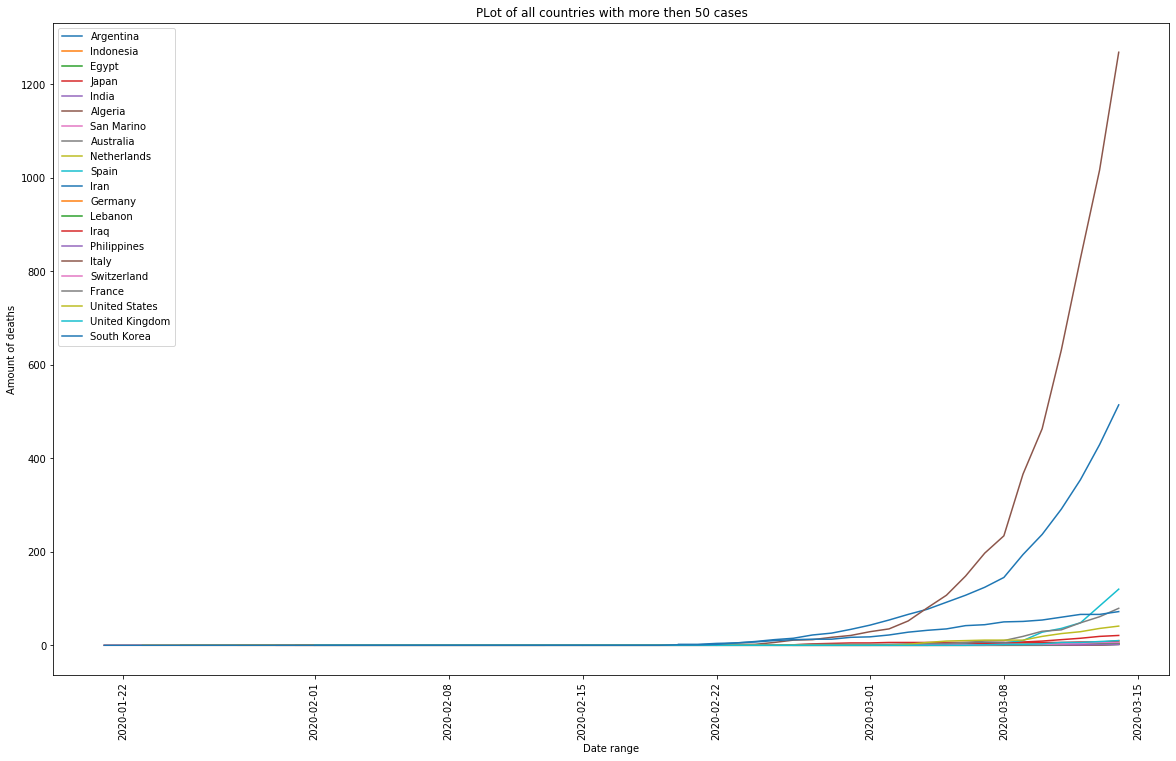

In [341]:
plot_death_cases(c_with_deaths, 'PLot of all countries with more then 50 cases', height = 12)

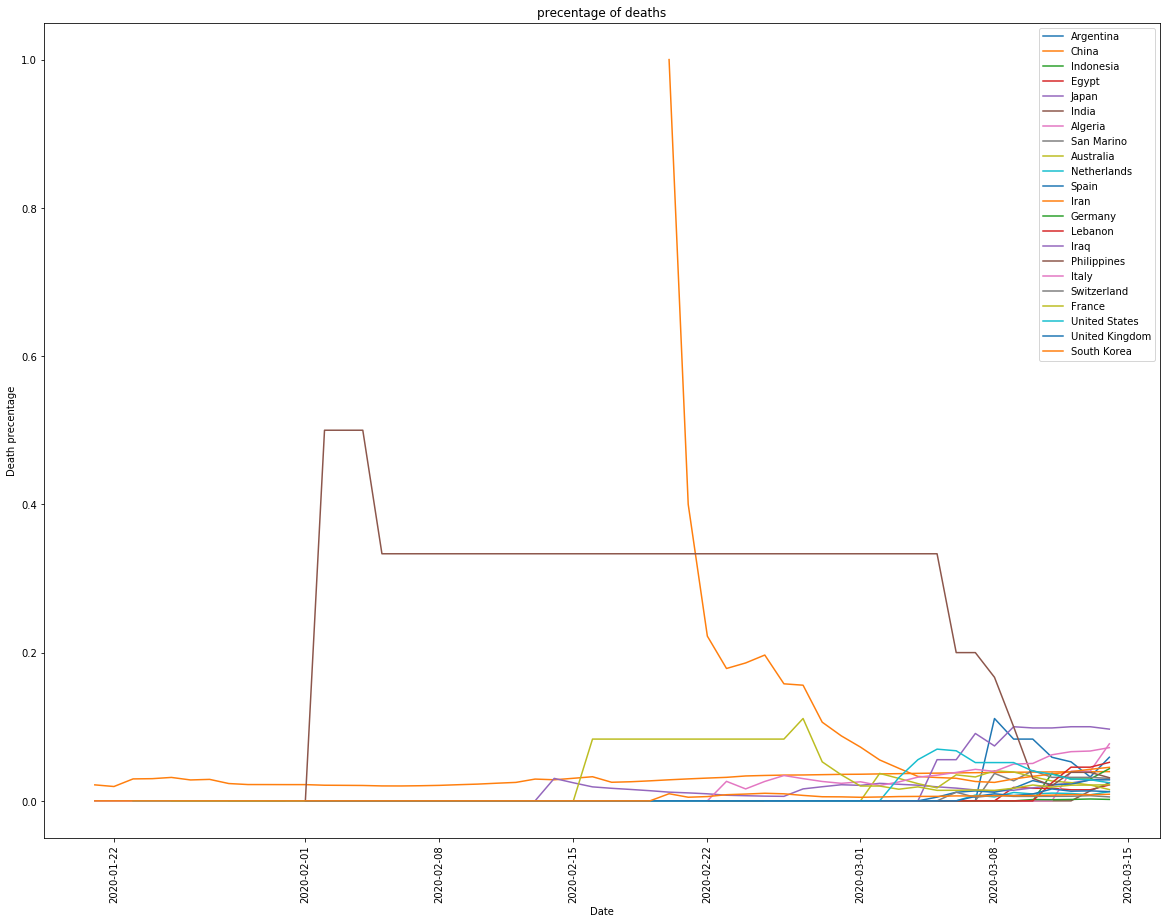

In [357]:
# deaths compared to infected (percentage)
plt.figure(figsize=(20,15))
stats = []
for country in c_with_deaths:
    plt.plot(death_rate(full_set, country)['date'], death_rate(full_set, country)['DR'], label=country)
    current =  death_rate(full_set, country)['DR'][-1:].values[0]
    mean_d = death_rate(full_set, country)['DR'].mean()
    max_d = death_rate(full_set, country)['DR'].max()
    min_d = death_rate(full_set, country)['DR'].min()
    std_d = death_rate(full_set, country)['DR'].std()
    stats.append([country, current, mean_d, max_d, min_d, std_d])
plt.ylabel("Death precentage")
plt.xlabel('Date')
plt.title('precentage of deaths')
plt.xticks(rotation = 90)
plt.legend()
plt.show()

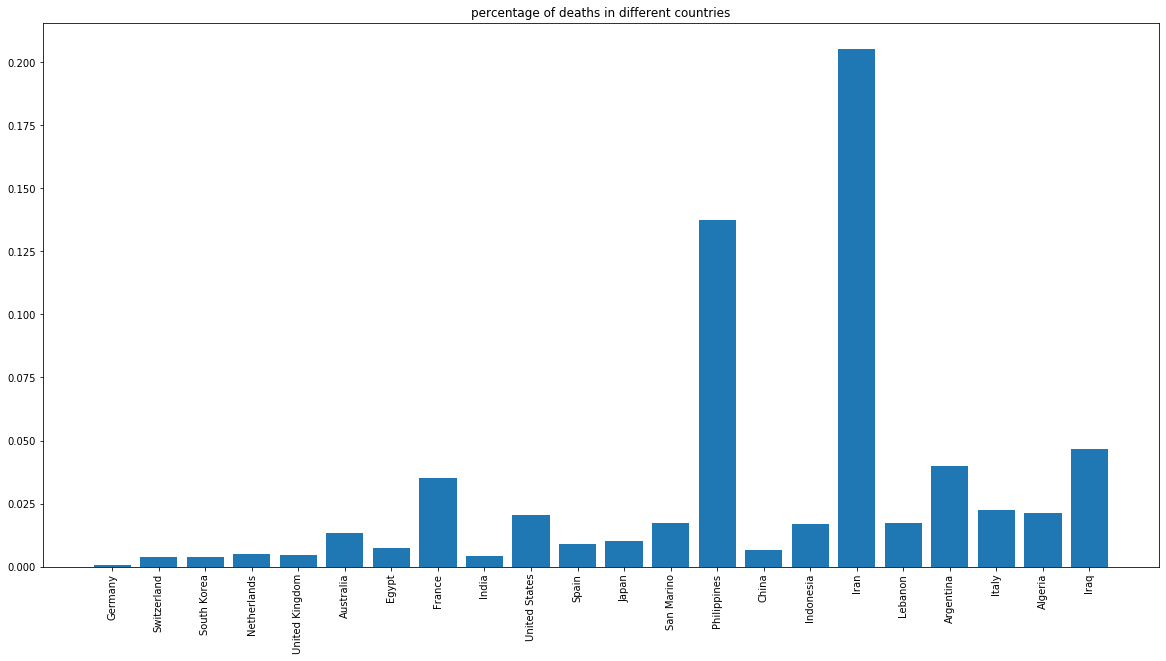

In [363]:
# Plot a Bar chart with the death rates
df = pd.DataFrame.from_records(stats)
#df.to_csv('test.csv')   #write to csv for further processing of the visualization.
df = df.sort_values(1)

# Plot a bar-chart with growth-rate
plt.figure(figsize=(20,10))
plt.bar(df[0], df[5], width=0.8)

plt.title('percentage of deaths in different countries')
plt.xticks(rotation = 90)
plt.show()

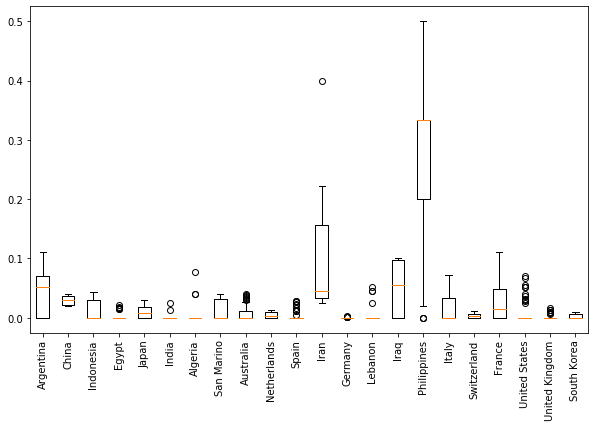

In [387]:
#fig = plt.figure(figsize=(20,10))
data = []
for country in c_with_deaths:
    data.append(death_rate(full_set, country)['DR'])
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.boxplot(data)
bp = ax1.set_xticklabels(c_with_deaths, rotation=90)